<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/WithL1L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       #transforms.RandomHorizontalFlip(0.1),
                                       #transforms.RandomResizedCrop(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 16
       
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 16
      

        self.pool2 = nn.MaxPool2d(2,2) # output_size = 8
        
        # TRANSITION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
        ) # output_size = 8
  
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x) 
        x = self.convblock4(x)
        
        x = self.pool2(x)    
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 20, 28, 28]           1,800
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
           Dropout-7           [-1, 20, 28, 28]               0
         MaxPool2d-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 10, 16, 16]             200
           Conv2d-10           [-1, 20, 16, 16]           1,800
             ReLU-11           [-1, 20, 16, 16]               0
      BatchNorm2d-12           [-1, 20, 16, 16]              40
          Dropout-13           [-1, 20, 16, 16]               0
        MaxPool2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  LAMBDA =  0.0001

  criterion = nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    l1_reg_loss = 0
    for param in model.parameters():
      l1_reg_loss += torch.sum(abs(param))

    classify_loss = criterion(y_pred, target)

    #loss = F.nll_loss(y_pred, target)

    loss = classify_loss + LAMBDA * l1_reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

def find_actual_pred_map(model, num=25):
  images=[]
  target_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d , t , p in zip(data, target, pred):
        if t!=p:
          d = d.cpu().numpy()
          t = t.cpu().numpy()
          p = p.cpu().numpy()
          d = (d*0.3081)+0.1307
          images.append(d)
          target_list.append(t)
          pred_list.append(p)
          count+=1
        if count == num:
          return images, target_list, pred_list

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

images, targ, pred = find_actual_pred_map(model, 25)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.25971949100494385 Batch_id=937 Accuracy=89.76: 100%|██████████| 938/938 [00:19<00:00, 48.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9754/10000 (97.54%)

EPOCH: 1


Loss=0.14107871055603027 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:19<00:00, 57.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.17289859056472778 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:19<00:00, 47.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.07402912527322769 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.1844320297241211 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:20<00:00, 46.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.08668947219848633 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.13111427426338196 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:19<00:00, 47.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.07372985780239105 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:19<00:00, 54.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.12669271230697632 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:19<00:00, 51.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.07125735282897949 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.08554896712303162 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:19<00:00, 47.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.07992246001958847 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:19<00:00, 47.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9896/10000 (98.96%)

EPOCH: 12


Loss=0.1162334755063057 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:19<00:00, 47.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.24098211526870728 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:19<00:00, 47.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.0870537981390953 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:19<00:00, 47.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9885/10000 (98.85%)

EPOCH: 15


Loss=0.07691395282745361 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:19<00:00, 47.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.08896247297525406 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:19<00:00, 47.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.18829110264778137 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:19<00:00, 48.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9901/10000 (99.01%)

EPOCH: 18


Loss=0.13812369108200073 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:19<00:00, 47.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9907/10000 (99.07%)

EPOCH: 19


Loss=0.07157856225967407 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:19<00:00, 47.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.09327630698680878 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:19<00:00, 48.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9920/10000 (99.20%)

EPOCH: 21


Loss=0.07105493545532227 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)

EPOCH: 22


Loss=0.31886136531829834 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:19<00:00, 47.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.16865244507789612 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:19<00:00, 46.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

EPOCH: 24


Loss=0.07660667598247528 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 25


Loss=0.14839684963226318 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:19<00:00, 47.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9905/10000 (99.05%)

EPOCH: 26


Loss=0.16376858949661255 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:19<00:00, 47.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9910/10000 (99.10%)

EPOCH: 27


Loss=0.07131852209568024 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.92%)

EPOCH: 28


Loss=0.07113229483366013 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:19<00:00, 47.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 29


Loss=0.1292799413204193 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 47.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 30


Loss=0.07941535115242004 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:19<00:00, 54.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 31


Loss=0.1258717179298401 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 32


Loss=0.06678536534309387 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:19<00:00, 48.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 33


Loss=0.06675933301448822 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9904/10000 (99.04%)

EPOCH: 34


Loss=0.06847277283668518 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:19<00:00, 47.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9908/10000 (99.08%)

EPOCH: 35


Loss=0.08003868162631989 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:19<00:00, 47.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9905/10000 (99.05%)

EPOCH: 36


Loss=0.12356531620025635 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:19<00:00, 48.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9915/10000 (99.15%)

EPOCH: 37


Loss=0.08676587790250778 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 38


Loss=0.0668545588850975 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 39


Loss=0.1000860184431076 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 47.77it/s]



Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

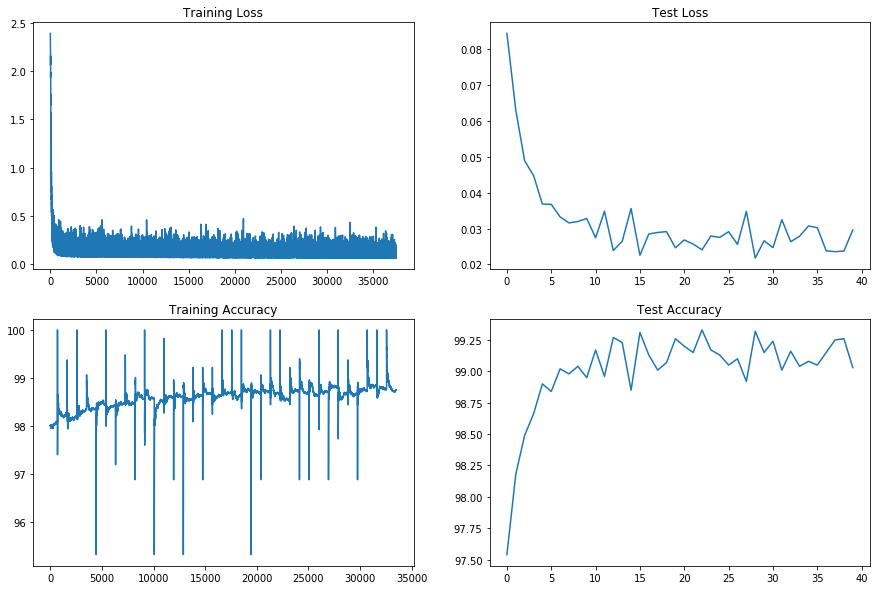

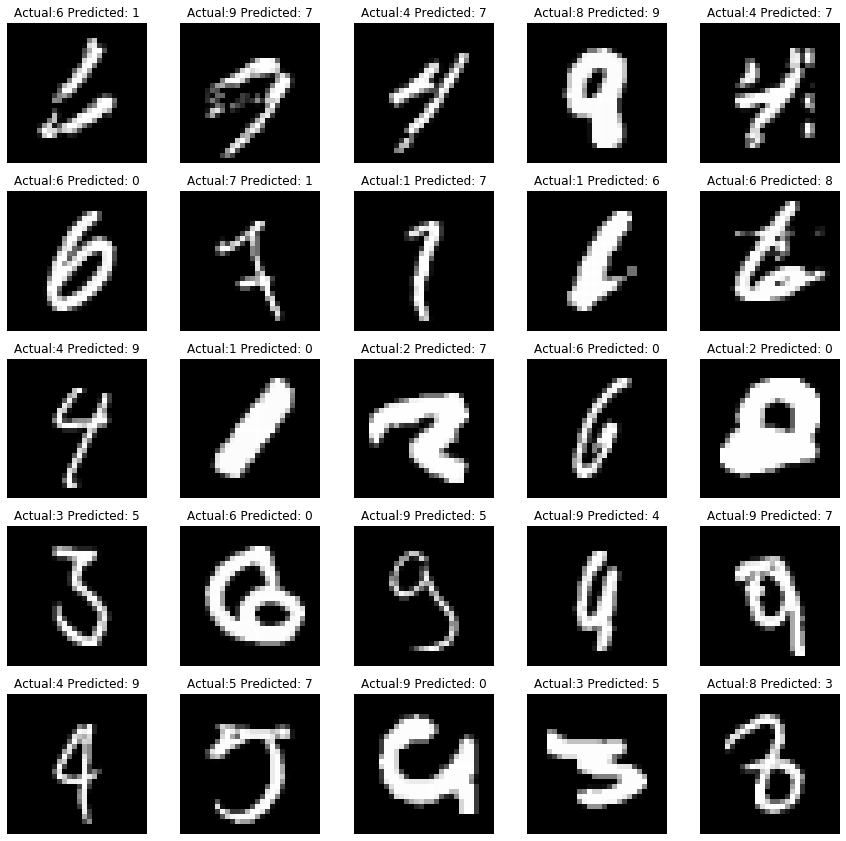

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

fig = plt.figure(figsize=(15, ((25//5)+1)*3))

for i in range(0, 25):
  ax=fig.add_subplot((25//5)+1, 5, i+1)
  ax.imshow(np.rollaxis(images[i], 0, 3).squeeze(), cmap='gray')
  ax.axis('off')
  ax.set_title("Actual:"+str(targ[i])+" Predicted: "+str(pred[i]))

plt.savefig('L1_REG.png')
plt.show()



In [0]:
TARGET: Improve train and test accuracy to reach desired targets within 15 epoch

RESULT: Achieved the target , got 99.45 % test accuracy in EPOCH 13 and there after results remained closer to this accuracy in rest of the epochs.Also the train accuracy slightly improved compared to the previous one.

         Total Params: 9,482
         Best train accuracy: 99.00
         Best test accuracy:  99.45

ANALYSIS: Did not apply drop out in Conv5 layer.Also adding second max pooling earlier has increased the RF to 56